In [1]:
import re
import math
import pickle
import time

from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi']= 200

import torch
from torch import optim, nn
from torch.autograd import Variable

import model_to_human_decision_torch 
from model_to_human_decision_torch import get_parameters_across_models

## load task data

In [2]:
task_data_csv='data_exp_22452-v9_task-ax2v.csv'

In [3]:
def prepare_tidy_protocol(csv_path,do_remove_within_subject_repetitions=True):
    df=pd.read_csv(csv_path)
    
    df=df.loc[df.Response.notna(),:] #drop non-response lines
    df=df.rename(columns={'source':'source_set 1'}) # fix a mistake in model naming
    df=df.rename(columns={'counterbalance-o1ql':'set_num'})

    # transform set columns to trial columns
    p = re.compile('(.+)_set \d+')
    set_columns=[s for s in list(df.columns) if p.match(s)]
    columns_to_keep=['Participant External Session ID','Event Index','Reaction Time','Response','set_num']+set_columns
    columns_to_drop=list(np.setdiff1d(df.columns,columns_to_keep))
    df=df.drop(columns=columns_to_drop)
    columns_to_build=list(np.unique([p.findall(s)[0] for s in set_columns]))
    for index,row in df.iterrows():
        cur_set=row['set_num']
        for c in columns_to_build:
            df.loc[index,c]=df.loc[index,c+'_'+cur_set]
    df=df.drop(columns=set_columns+['set_num'])

    # make sure the sentence pairs are alphabetically sorted
    def sort_sentence_pairs(df1):    
        flip_dict={'sentence1':'sentence2','sentence2':'sentence1',
                   'sentence1_model':'sentence2_model','sentence2_model':'sentence1_model'}
        df2=df1.copy()    
        for index, row in df2.iterrows():
            if row['sentence1']>row['sentence2']: # a flip is needed
                for old_col, new_col in flip_dict.items():
                    df2.loc[index,new_col]=df1.loc[index,old_col]
        return df2
    df=sort_sentence_pairs(df)

    # separate models and levels
    p=re.compile('(.+)_(\d+)')
    df['sentence1_model_name']=[p.findall(s)[0][0] for s in df['sentence1_model']]
    df['sentence2_model_name']=[p.findall(s)[0][0] for s in df['sentence2_model']]
    df['sentence1_model_level']=[int(p.findall(s)[0][1]) for s in df['sentence1_model']]
    df['sentence2_model_level']=[int(p.findall(s)[0][1]) for s in df['sentence2_model']]
    df=df.drop(columns=['sentence1_model','sentence2_model'])

    # mark choice indecis
    for index,row in df.iterrows():
        df.loc[index,'Choice']=[row.sentence1, row.sentence2].index(row.Response)

    df['sentence_pair_id']=[s1+'_'+s2 for s1,s2 in zip(df.sentence1, df.sentence2)]

    # renumber subjects
    df.drop(columns='subject') # there's some issue here    
    uq_subjects, ind, unique_inverse = np.unique(df['Participant External Session ID'], return_index=True,return_inverse=True)
    uq_subjects=list(uq_subjects[np.argsort(ind)]) # unique subjects by order of appearance    
    df['subject']=[uq_subjects.index(s) for s in df['Participant External Session ID']]
                   
    # optionally, remove all but first occurance of each sentence pair within a subject    
    if do_remove_within_subject_repetitions:
        def remove_within_subject_repetitions(df1):
            # keep only the first appearance of each sentence pair within a subject
            _,unique_indices=np.unique(df1.sentence_pair_id,return_index=True)
            df2=df1.loc[np.in1d(np.arange(len(df1)),unique_indices),:]    
            return df2
        old_length=len(df)
        df=df.groupby('subject').apply(remove_within_subject_repetitions)
        print("removed {} within-subject repeating trials.".format(old_length-len(df)))
        
    df=df.set_index(['subject','trial']).sort_values(by=['subject','trial'],axis=0).reset_index()
    
    # a final sanity check: 
    assert len(np.unique(df['sentence_pair_id']))==len(df.drop_duplicates(subset=['sentence1','sentence2'])), 'number of sentences pairs must match number of sentence pair ids'
    
    return df
protocol=prepare_tidy_protocol(task_data_csv)


removed 70 within-subject repeating trials.


In [4]:
n_total_trials=len(protocol)
n_sentence_pairs=len(np.unique(protocol['sentence_pair_id']))
n_subjects=len(np.unique(protocol['Participant External Session ID']))
print("loaded {} total trials with {} sentence pairs and {} subjects.".format(n_total_trials,n_sentence_pairs,n_subjects))

loaded 1360 total trials with 605 sentence pairs and 13 subjects.


In [5]:
protocol

,subject,trial,Event Index,Participant External Session ID,Reaction Time,Response,sentence1,sentence2,source,sentence1_model_name,sentence2_model_name,sentence1_model_level,sentence2_model_level,Choice,sentence_pair_id
0,0,1.0,4,5f89a28900ebf4068239ad58,5812.220,What public schools teach their students is co...,I can not long conceal my dreadful sin,What public schools teach their students is co...,internet,xlm,xlm,1,0,1.0,I can not long conceal my dreadful sin_What pu...
1,0,2.0,6,5f89a28900ebf4068239ad58,5300.000,And that consists of a number of factors,And that consists of a number of factors,Birmingham but the heavy duty cell one and,generator,electra,electra,9,5,0.0,And that consists of a number of factors_Birmi...
2,0,3.0,8,5f89a28900ebf4068239ad58,9964.815,Dad of a stagnant fermentation shrimp of doubts,Dad of a stagnant fermentation shrimp of doubts,Mel causal that foothold overflowed paid Cpl a...,generator,bilstm,bilstm,5,0,0.0,Dad of a stagnant fermentation shrimp of doubt...
3,0,4.0,10,5f89a28900ebf4068239ad58,11878.520,Brisbane corp distant and finished commandos c...,Brisbane corp distant and finished commandos c...,The frustrating and bananas and the modificati...,generator,bigram,bigram,2,6,0.0,Brisbane corp distant and finished commandos c...
4,0,5.0,12,5f89a28900ebf4068239ad58,12686.870,Listening those studied bails heater understan...,Hours into cults cables help arrive in mounts,Listening those studied bails heater understan...,generator,lstm,lstm,5,2,1.0,Hours into cults cables help arrive in mounts_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,12,106.0,214,5f919b517819d10212708607,2124.000,Activity biblical a disrupt of Nova Scotia rel...,Activity biblical a disrupt of Nova Scotia rel...,Raven toned benched homeowners boiler and hurr...,generator,bert_whole_word,bert_whole_word,4,2,0.0,Activity biblical a disrupt of Nova Scotia rel...
1356,12,107.0,216,5f919b517819d10212708607,1852.000,After that cry there was a deep sigh,After that cry there was a deep sigh,Be guarded in executing your ideas of right,internet,lstm,lstm,3,0,0.0,After that cry there was a deep sigh_Be guarde...
1357,12,108.0,218,5f919b517819d10212708607,1064.000,For those with understandable motives must bac...,Author of Causeway inactivity notation and exc...,For those with understandable motives must bac...,generator,gpt2,gpt2,4,7,1.0,Author of Causeway inactivity notation and exc...
1358,12,109.0,220,5f919b517819d10212708607,1101.000,Stress increases bungalow wall and respiration...,Oslo slammed prerequisite unequal questioned q...,Stress increases bungalow wall and respiration...,generator,bert,bert,0,3,1.0,Oslo slammed prerequisite unequal questioned q...


## Evaluate negative log-likelihood of choice predictions given as pandas dataframe

In [6]:
def evaluate_NLL(subject_data,predictions,mode='sum',deal_with_missing_predictions='omit',return_non_agg_NLL=False):
    """ evaluate the negative-log-likelihood of human response data given model predictions.
    
    subject_data (pd.DataFrame) a dataframe such as the one returned from prepare_tidy_protocol. Should contain 'subject' (str), 'sentence_pair_id' (str) and 'Choice' (either 0 or 1).
    predictions (pd.DataFrame) model predictions. 
        Should contain sentence_pair_id (str), and either 'choice_0_prob' and 'choice_1_prob' or 'choice_0_log_prob' and 'choice_1_log_prob': 
        the (log) probabilitiy of choosing sentence 0 or the other one.
        the predictions dataframe can contain also a 'subject' column for subject specific-predictions
    mode (str) 'sum' or 'mean' (how NLL is aggregeated).
    deal_with_missing_predictions (str) 'omit' - deletes trials with no predictions. uniform predictions - uses a p=0.5 prediction.
    return_non_agg_NLL (boolean)
    
    returns:
    if return_non_agg_NLL is True, (aggregated dataframe, original dataframe)
    else, only the aggregated dataframe
    both return dataframes contain a new columns NLL - negative-log-likelihood
    
    """
    if 'subject' in predictions.columns: # predictions are subject-specific
        df=subject_data.merge(predictions,how='left',on=['sentence_pair_id','subject'])
    else: # same predictions for all subjects
        df=subject_data.merge(predictions,how='left',on=['sentence_pair_id'])
    c=np.asarray(subject_data.Choice,dtype=float)
    
    if 'choice_0_log_prob' in predictions.columns and 'choice_1_log_prob' in predictions.columns:
        log_p=np.where(c==0,df.choice_0_log_prob,df.choice_1_log_prob)
        log_p=np.where(np.isnan(c),np.nan,log_p)
    elif 'choice_0_prob' in predictions.columns and 'choice_1_prob' in predictions.columns:
        p=np.where(c==0,df.choice_0_prob,df.choice_1_prob)
        p=np.where(np.isnan(c),np.nan,p)
        log_p=np.log(p)
    else:
        raise ValueError('predictions must include either choice_0_log_prob and choice_1_log_prob or choice_0_prob and choice_1_prob')
    
    df['NLL']=-log_p
    
    # deal with trials for which we have no predictions:
    missing_predictions=np.logical_and(df['NLL'].isna(),np.logical_not(np.isnan(c))) # there's no prediction but the subject made a choice
    
    if np.any(missing_predictions):
        print('Found {} missing predictions. Handling strategy: {}.'.format(np.sum(missing_predictions),deal_with_missing_predictions))
        if deal_with_missing_predictions=='omit':
            df=df.loc[np.logical_not(missing_predictions),:] # drop these trails
        elif deal_with_missing_predictions=='uniform predictions':
            df[missing_predictions,'NLL']=-np.log(0.5) # make a uniform prediction
        else:
            raise ValueError("invalid deal_with_missing_predictions")
    
    # aggregate NLL
    if mode=='sum':
        agg_NLL=df.NLL.sum().item()        
    elif mode=='mean':
        agg_NLL=df.NLL.mean().item()
    if return_non_agg_NLL:
        return agg_NLL, df
    else:
        return agg_NLL

## Upper and lower bounds on the noise ceiling

In [7]:
def get_ub_noise_ceiling_predictions(subject_data):    
    # calculate human choice probability per sentence (collapsed over subjects and within-subject repetitions)
    df=subject_data.copy()
    df['chose_0']=np.asarray(subject_data.Choice==0,np.float)
    df['chose_0'].loc[np.isnan(subject_data.Choice)]==np.nan
    df2=df.groupby(['sentence1','sentence2','sentence_pair_id'])['chose_0'].mean()
    df2=df2.drop(columns=['subject']).reset_index().rename(columns={'chose_0':'choice_0_prob'})
    df2['choice_1_prob']=1.0-np.asarray(df2.choice_0_prob)
    return df2
ub_NC_predictions=get_ub_noise_ceiling_predictions(protocol)

def get_lb_noise_ceiling_predictions(subject_data):
    # calculate leave-one-subject out human choice probability per sentence (collapsed over subjects and within-subject repetitions)
    subjects=list(np.unique(subject_data.subject))
    df1=subject_data.copy()
    df1['chose_0']=np.asarray(df1.Choice==0,np.float)
    df1['chose_0'].loc[np.isnan(df1.Choice)]==np.nan
    
    subject_specific_predictions_dfs=[]
    for subject in subjects: # leave one-subject out cross-validation:
        without_subject_df=df1.copy().loc[df1.subject!=subject,:] # hold out one subject            
        subject_specific_predictions=without_subject_df.groupby(['sentence1','sentence2','sentence_pair_id'])['chose_0'].mean() # mean choice probabilities of the remaining subjects        
        subject_specific_predictions=subject_specific_predictions.reset_index().rename(columns={'chose_0':'choice_0_prob'})
        subject_specific_predictions['choice_1_prob']=1.0-np.asarray(subject_specific_predictions.choice_0_prob)                
        subject_specific_predictions.loc[:,'subject']=subject # we mark the resulting predictions as subject-specific predictions
        
        # next, we remove predictions for sentence pairs the subject didn't see:
        cur_subject_df=df1.copy().loc[df1.subject==subject,:] 
        cur_subject_sentence_pair_ids=np.unique(cur_subject_df.sentence_pair_id) # these are the sentences the subject saw
        subject_specific_predictions=subject_specific_predictions.loc[np.in1d(subject_specific_predictions.sentence_pair_id,cur_subject_sentence_pair_ids),:]                
        subject_specific_predictions_dfs.append(subject_specific_predictions) # and add the remaining predictions to the list
    
    lb_NC_predictions=pd.concat(subject_specific_predictions_dfs)
    
    return lb_NC_predictions
lb_NC_predictions=get_lb_noise_ceiling_predictions(protocol)
    
ub_NC_NLL=evaluate_NLL(protocol,ub_NC_predictions,mode='sum')
print("upper noise ceiling NLL",ub_NC_NLL)

# # without a Gamma parameter, the lower noise ceiling can be infinity
# lb_NC_NLL,df=evaluate_NLL(protocol,lb_NC_predictions,mode='sum',return_non_agg_NLL=True)
# print("lower noise ceiling NLL",lb_NC_NLL)

upper noise ceiling NLL 448.9342475934038


In [8]:
ub_NC_predictions

,sentence1,sentence2,sentence_pair_id,choice_0_prob,choice_1_prob
0,A agony it Rapids and the bikini dipping,Most are the names of arrogance native land,A agony it Rapids and the bikini dipping_Most ...,0.0,1.0
1,A agony it Rapids and the bikini dipping,The Marina is a sailing boat from Scotland,A agony it Rapids and the bikini dipping_The M...,0.0,1.0
2,A and had to the past it again,The overpowering the lawn of such a year,A and had to the past it again_The overpowerin...,0.5,0.5
3,A case of driver replacements involved John Bowe,It includes notable people in the modern era,A case of driver replacements involved John Bo...,0.5,0.5
4,A civilization that was the largest weighing in,Talent beaches mirroring the publicly block tr...,A civilization that was the largest weighing i...,1.0,0.0
...,...,...,...,...,...
600,This tarnished devising of seconded cruelty an...,To retroactively your team of style and workout,This tarnished devising of seconded cruelty an...,0.0,1.0
601,Too much separates relax fabric choral rudder ...,Use it for this and many other things,Too much separates relax fabric choral rudder ...,0.0,1.0
602,Trust reflect slugging draped robots shoe firs...,Worth a turkey license issuance fortune choppe...,Trust reflect slugging draped robots shoe firs...,0.5,0.5
603,Was excited when I saw the awesome formatting,We were fools not to have known it,Was excited when I saw the awesome formatting_...,0.0,1.0


### Pseudo sentence log-probabilities
In order to deal with the noise ceiling estimates in the same fashion we deal with the deep nets' outputs, we convert their choice probabilities pseudo-sentence probabilities

In [9]:
def pseudo_sentence_probs(p_choice_1,p_choice_2,pseudo_sentence_prob_gamma=1.234,eps=1e-8):
    p_choice_1=np.clip(p_choice_1,eps,1-eps)
    p_choice_2=np.clip(p_choice_2,eps,1-eps)
    
    s1a_b=-np.log((1-p_choice_1)/p_choice_1)*pseudo_sentence_prob_gamma  
    lp1=-100+s1a_b/2
    lp2=-100-s1a_b/2

    return lp1,lp2

### Prepare model predictions

In [10]:
models=['bigram','trigram','rnn','lstm','bilstm','bert','bert_whole_word','roberta','xlm','electra','gpt2','ub_NC','lb_NC']

comp_models=list(np.setdiff1d(models,['ub_NC','lb_NC']))
human_models=list(np.setdiff1d(models,comp_models))

def get_cached_sentence_log_probabilities_for_model(model_name,protocol):
    """ build a pandas dataframe of model raw sentence probabilities using cached model outputs"""
    f = open(model_name+'_expt1_sentence_probs.pkl','rb')
    prob_dict=pickle.load(f)
    model_predictions=protocol[['sentence1','sentence2','sentence_pair_id']].drop_duplicates().reset_index(drop=True) 
    for i_row, row in model_predictions.iterrows():
        model_predictions.at[i_row,'sentence1_raw_log_prob']=prob_dict[row['sentence1']]
        model_predictions.at[i_row,'sentence2_raw_log_prob']=prob_dict[row['sentence2']]
    return model_predictions

def noise_ceiling_to_pseudo_log_probabilities(NC_predictions):
    """ recast trial-specific noise ceiling predictions to be language-model like """
    NC_predictions=NC_predictions.copy()
    p1=NC_predictions['choice_0_prob']
    p2=NC_predictions['choice_1_prob']
    assert np.isfinite(p1).all() and np.isfinite(p2).all(), 'found nan predictions for subject {}: {}).'.format(trial.subject,trial.sentence_pair_id)
    log_p1,log_p2=pseudo_sentence_probs(p1,p2)
    NC_predictions['sentence1_raw_log_prob']=log_p1
    NC_predictions['sentence2_raw_log_prob']=log_p2
    NC_predictions.drop(columns=['choice_0_prob','choice_1_prob'])
    return NC_predictions

model_sentence_predictions=OrderedDict() # this will hold a dataframe for each model

for model_name in models:
    if model_name in comp_models:
        model_sentence_predictions[model_name]=get_cached_sentence_log_probabilities_for_model(model_name,protocol)
    elif model_name=='ub_NC':
        model_sentence_predictions[model_name]=noise_ceiling_to_pseudo_log_probabilities(ub_NC_predictions)
    elif model_name=='lb_NC':
        model_sentence_predictions[model_name]=noise_ceiling_to_pseudo_log_probabilities(lb_NC_predictions)
    else:
        raise ValueError

In [11]:
# an example:
model_sentence_predictions['lb_NC']

,sentence1,sentence2,sentence_pair_id,choice_0_prob,choice_1_prob,subject,sentence1_raw_log_prob,sentence2_raw_log_prob
9,A naturally occurring replies punishment exami...,This country uses collaborative ping internal ...,A naturally occurring replies punishment exami...,0.0,1.0,0,-111.36556,-88.63444
10,A poets piped enquiry a lot of it,The growing spectral and thus attain the bandit,A poets piped enquiry a lot of it_The growing ...,0.0,1.0,0,-111.36556,-88.63444
11,A poster and employer approval rating and vows,The next to the time and historical park,A poster and employer approval rating and vows...,1.0,0.0,0,-88.63444,-111.36556
37,Also their navy is in a dismal state,He had never told us he was married,Also their navy is in a dismal state_He had ne...,0.5,0.5,0,-100.00000,-100.00000
46,And also as used in the plant printers,Hank rusted transcended youthful tiles manslau...,And also as used in the plant printers_Hank ru...,0.5,0.5,0,-100.00000,-100.00000
...,...,...,...,...,...,...,...,...
570,The glazing researcher oversees is senators co...,These suburbs are shining the ballot favourite...,The glazing researcher oversees is senators co...,0.0,1.0,12,-111.36556,-88.63444
572,The hardware and settings doable relaying fell...,The peace answered and amassed more Ethel zones,The hardware and settings doable relaying fell...,0.5,0.5,12,-100.00000,-100.00000
580,The open space was almost circular in shape,We wish him the best in the future,The open space was almost circular in shape_We...,0.0,1.0,12,-111.36556,-88.63444
596,These tables were lists of those who participate,Turnpike Gutierrez at newcomer golfers may ste...,These tables were lists of those who participa...,0.5,0.5,12,-100.00000,-100.00000


In [12]:
def fit_model_decision_parameters(protocol,model_predictions,decision_model_class='FixedWidthSquashing',device='cpu',optimizer='LBFGS',minps=None,max_steps_without_improvement=10,return_dataframes=True,verbose=True):
    """ fit the model decision hyper-parameter given a human data (protocol) and sentence predictions 
    
    args:
    protocol (pd.dataframe) must include a sentence_pair_id column
    model_prediction (pd.dataframe) must include a sentence_pair_id column as well as sentence1_raw_log_prob and sentence2_raw_log_prob
    decision_model_class (str) name of class to import from model_to_human_decision_torch. Currently implemented: 'Naive', 'NoSquashing', 'FixedWidthSquashing', 'VariableWidthSquashing', 'SquashedSoftmax'
    device (str) torch device. cpu is faster for float64
    optimizer (str) 'LBFGS' or 'Adam'
    minps (float) initial values for the squashing parameter
    max_steps_without_improvement (int) when to stop when not improving
    return_dataframes (boolean) see below
    verbose (boolean) show messages
    
    returns:
    if return_dataframes is True:
        decision_model (ModelToHumanDecision) a fitted decision model object
        parameters_dict (dict) the fitted parameters
        protocol_with_NLL (pd.dataframe) the protocol with additional NLL column (trial-specific NLL)
        adjusted_model_predictions (pd.dataframe) the model predictions with additional columns for human choice probabilities
    otherwise:
        decision_model, parameters_dict        
    """    
    
    if 'subject' in model_predictions.columns:
        identifiers=['subject','sentence1','sentence2','sentence_pair_id']
    else:
        identifiers=['sentence1','sentence2','sentence_pair_id']
        
    merged=protocol.merge(model_predictions,on=identifiers)  
    
    log_p1=torch.tensor(merged['sentence1_raw_log_prob'],device=device,dtype=torch.float64)
    log_p2=torch.tensor(merged['sentence2_raw_log_prob'],device=device,dtype=torch.float64)
    response_ind=torch.tensor(merged['Choice'],device=device,dtype=int)
    
    parameters={}
    if decision_model_class in ['FixedWidthSquashing','VariableWidthSquashing']:
        if minps is None: # get minimal sentence log-probability to serve as initial value for the squashing parameters
            minps=abs(log_p1.mean()+log_p2.mean())/2
        parameters['squashes']=minps
    
    # build decision model object
    decision_model=getattr(model_to_human_decision_torch,decision_model_class)(parameters=parameters,device=device)
    
    for par in decision_model.parameters():
        par.requires_grad=True
    
    if optimizer == 'Adam':
        opt = optim.Adam(decision_model.parameters(),lr=1.0)
    elif optimizer=='LBFGS':
        opt = optim.LBFGS(decision_model.parameters(),line_search_fn='strong_wolfe') # this is much faster!
    else:
        raise ValueError
      
    previous_loss=torch.tensor(np.inf,device=device)
   
    eps=1e-10
    non_improvement_counter=0
    t=time.time()
    for epoch in range(10000):

        opt.zero_grad()
        
        def calc_loss():
            global my_loss
            log_p_sent=decision_model(log_p1,log_p2)
            take_by_2nd_dim=lambda x, idx: x[torch.arange(x.size(0)), idx] 
            log_p_choice=take_by_2nd_dim(log_p_sent,response_ind)
            loss=log_p_choice.sum()     
            return loss
        
        def closure(): # require for LBFGS
            opt.zero_grad()
            loss=calc_loss()
            loss.backward()            
            return loss
    
        opt.step(closure)
    
        loss=calc_loss().detach()
        
        if (previous_loss-loss)<eps:
            non_improvement_counter+=1            
        else:            
            non_improvement_counter=0        
        previous_loss=loss.detach()
        
        if non_improvement_counter>=max_steps_without_improvement:
            if verbose:
                print('converged in',epoch,'epochs,',time.time()-t,'seconds')
            break
            
        if epoch%50==0 and verbose:            
            print('epoch: ', epoch, 'loss:',loss.item())
            # TODO: show parameters

            #     print(decision_model.get_parameters())
#     print('total loss:',loss)
#     for i_model,model_name in enumerate(models):
#         print('{} {:.2f}'.format(model_name,model_loss[i_model].item()))
        
    #breakpoint()
    if verbose:
        print("final loss ",loss.item())

    parameters_dict=decision_model.get_parameters()
    
    NLL=loss.item()
    
    if return_dataframes:        
        # trial-specific NLL
        log_p_sent=decision_model(log_p1,log_p2)
        take_by_2nd_dim=lambda x, idx: x[torch.arange(x.size(0)), idx] 
        log_p_choice=take_by_2nd_dim(log_p_sent,response_ind)
            
        protocol_with_NLL=protocol.copy()
        protocol_with_NLL['NLL']=log_p_choice.detach().cpu().numpy()
        adjusted_model_predictions=model_predictions.copy()
        
        with torch.no_grad():
            decision_log_prob=-decision_model(model_predictions.filter(regex='_raw_log_prob$',axis=1).to_numpy()).detach().cpu().numpy()
        adjusted_model_predictions['choice_0_log_prob']=decision_log_prob[:,0]
        adjusted_model_predictions['choice_1_log_prob']=decision_log_prob[:,1]
        adjusted_model_predictions=adjusted_model_predictions.drop(columns=['sentence1_raw_log_prob','sentence2_raw_log_prob','choice_0_prob','choice_1_prob'],errors='ignore')        
        return decision_model, parameters_dict, NLL, protocol_with_NLL, adjusted_model_predictions
    else:
        return decision_model, parameters_dict, NLL

decision_model, parameters_dict, NLL, protocol_with_NLL, adjusted_model_predictions=fit_model_decision_parameters(protocol,model_sentence_predictions['bert_whole_word'],decision_model_class='FixedWidthSquashing')

epoch:  0 loss: 848.2745597118528
converged in 10 epochs, 0.0767679214477539 seconds
final loss  848.2745597118528


In [13]:
# some sanity checks:
assert np.isclose(NLL,evaluate_NLL(protocol,adjusted_model_predictions,mode='sum'))
assert np.isclose(NLL,protocol_with_NLL['NLL'].sum())

### Compare different response models

In [26]:
results=[]
for optimizer in ['Adam','LBFGS']:
    for decision_model_class in ['NoSquashing', 'FixedWidthSquashing', 'VariableWidthSquashing', 'SquashedSoftmax']:
        for model in models:
            print (optimizer,decision_model_class,model,' ',end='')
            decision_model, parameters_dict, NLL, protocol_with_NLL, adjusted_model_predictions=fit_model_decision_parameters(protocol,model_sentence_predictions[model],decision_model_class=decision_model_class,optimizer=optimizer,verbose=False)
            assert np.isclose(NLL,evaluate_NLL(protocol,adjusted_model_predictions,mode='sum'))
            assert np.isclose(NLL,protocol_with_NLL['NLL'].sum())
            print(NLL)
            results.append({'model':model,'decision_model_class':decision_model_class,'optimizer':optimizer,'NLL':NLL})
results=pd.DataFrame(results)

Adam NoSquashing bigram  843.836774677728
Adam NoSquashing trigram  844.3703700854242
Adam NoSquashing rnn  855.2778913254051
Adam NoSquashing lstm  849.1152176304502
Adam NoSquashing bilstm  849.7134336935324
Adam NoSquashing bert  850.2793088562029
Adam NoSquashing bert_whole_word  851.837663900587
Adam NoSquashing roberta  846.714471541393
Adam NoSquashing xlm  849.5382710215147
Adam NoSquashing electra  845.9341909756622
Adam NoSquashing gpt2  844.0418413598013
Adam NoSquashing ub_NC  448.93425447314934
Adam NoSquashing lb_NC  923.0579157750864
Adam FixedWidthSquashing bigram  842.3455024354905
Adam FixedWidthSquashing trigram  844.609095704991
Adam FixedWidthSquashing rnn  842.8589088699008
Adam FixedWidthSquashing lstm  840.5802423512519
Adam FixedWidthSquashing bilstm  842.3298265242804
Adam FixedWidthSquashing bert  845.3801307763318
Adam FixedWidthSquashing bert_whole_word  848.274559712378
Adam FixedWidthSquashing roberta  841.2231383830754
Adam FixedWidthSquashing xlm  845.9

/home/tal/anaconda3/envs/contstimlang/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/tal/anaconda3/envs/contstimlang/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


(800.0, 900.0)

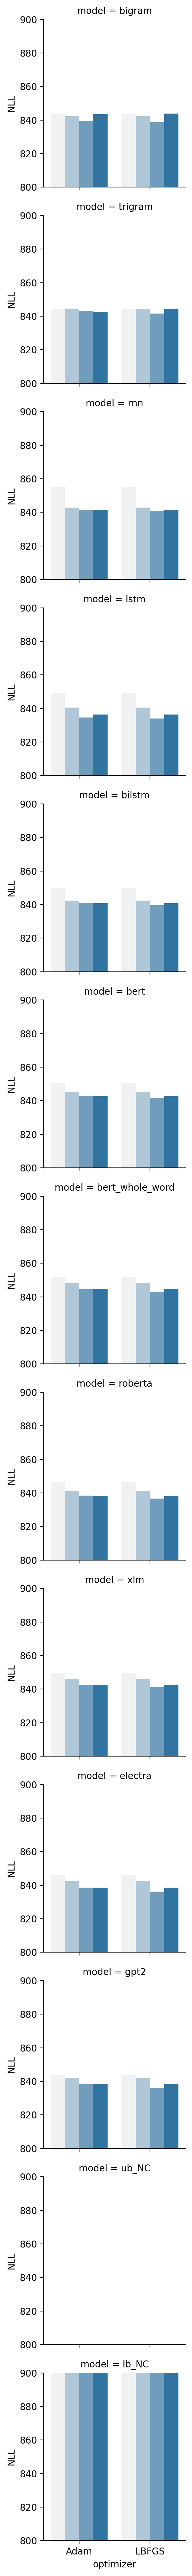

In [28]:
import seaborn as sns
g = sns.FacetGrid(results, row="model")
g.map(sns.barplot,'optimizer','NLL','decision_model_class')
plt.ylim([800,900])


### Organizing data for model fitting

In [ ]:

comp_models=list(np.setdiff1d(models,['ub_NC','lb_NC']))
human_models=list(np.setdiff1d(models,comp_models))

prob_dict=dict()
for model_name in comp_models:
    f = open(model_name+'_expt1_sentence_probs.pkl','rb')
    prob_dict[model_name]=pickle.load(f)

fitsets=[]
for i_subject in range(n_subjects):
    cur_sub_protocol=protocol.loc[protocol.subject==i_subject,:]
    
    fitset=[]
    for i_trial, trial in cur_sub_protocol.iterrows():
        for model_name in models:
            if model_name in comp_models:
                log_p1=prob_dict[model_name][trial.sentence1]
                log_p2=prob_dict[model_name][trial.sentence2]
                fitset.append([model_name,log_p1,log_p2,trial.Choice])
            if model_name in human_models:
                # get predictions from dataframe 
                predictions_df={'ub_NC':ub_NC_predictions,'lb_NC':lb_NC_predictions}[model_name]                
                if 'subject' in predictions_df.columns: # deal with subject-specific predictions
                    filter_vars=['sentence_pair_id','subject']
                else:
                    filter_vars=['sentence_pair_id']
                    
                cur_prediction=trial.to_frame().T.merge(predictions_df,how='left',on=filter_vars)
                assert len(cur_prediction)==1, 'exactly one prediction should be provided for each trial (found {} for subject {}: {}).'.format(len(cur_prediction),trial.subject,trial.sentence_pair_id)
                                    
                p1=cur_prediction.loc[0,'choice_0_prob']
                p2=cur_prediction.loc[0,'choice_1_prob']
                
                assert np.isfinite(p1) and np.isfinite(p2), 'found nan predictions for subject {}: {}).'.format(trial.subject,trial.sentence_pair_id)
                
                log_p1,log_p2=pseudo_sentence_probs(p1,p2)
                fitset.append([model_name,log_p1,log_p2,trial.Choice])
            
    fitsets.append(fitset)

fitsets_all=[]
for fitset in fitsets:
    fitsets_all+=fitset


### Get model-specific ranges of sentence probabilities (used to initiate squash parameters)

In [ ]:
minps=[]
for m in models:
    m=np.min([np.min([trial[1],trial[2]]) for trial in fitsets_all if trial[0]==m])
    minps.append(m)
    
minps=np.abs(minps)


maxps=[]
for m in models:
    m=np.max([np.max([trial[1],trial[2]]) for trial in fitsets_all if trial[0]==m])
    maxps.append(m)
    
maxps=np.abs(maxps)



### Fit human-decision models

In [ ]:
from collections import defaultdict

# possible decision models implemented: 'Naive', 'NoSquashing', 'FixedWidthSquashing', 'VariableWidthSquashing', 'SquashedSoftmax'
decision_model_class='FixedWidthSquashing'

device='cpu'

for boot in range(1):
    
    if boot == 0: # original order
        boots=np.arange(n_subjects)
    else: # bootstrap subjects
        boots=np.random.choice(n_subjects,n_subjects)
    
    fitset=[]
    for b in boots:
        fitset+=fitsets[b]
    
    trainable_parameters_across_models=[]
    
    # define a human decision model for each model
    decision_model=OrderedDict()
    for i_model, model in enumerate(models):
        parameters={}
        if decision_model_class in ['FixedWidthSquashing','VariableWidthSquashing']:
            parameters['squashes']=minps[i_model] # use minimal sentence probability as the initial value for squashing parameter
        model_class=getattr(model_to_human_decision_torch,decision_model_class)
        decision_model[model]=model_class(parameters=parameters,device=device)
        for par in decision_model[model].parameters():
            par.requires_grad=True
        trainable_parameters_across_models.extend(decision_model[model].parameters())
        
    opt = optim.Adam(trainable_parameters_across_models,lr=1)

    print(boot)
    print('')

    # build models by trials by sentences log-prob matrix
    
    log_p1=defaultdict(list)
    log_p2=defaultdict(list)
    response_ind=defaultdict(list)
    
    for trial in fitset:
        model1_name=trial[0]
        log_p1[model1_name].append(trial[1])
        log_p2[model1_name].append(trial[2])
        response_ind[model1_name].append(trial[3])        
    
    for epoch in range(1000): # for some models, one needs more than 200 epochs for convergence. TODO - replace this loop with a convergence criterion.

        loss = torch.tensor(0.,device=device,requires_grad = True)
        
        model_loss=torch.zeros((len(models)),device=device)
        
        for i_model,model_name in enumerate(models):
            log_p_sent=decision_model[model_name](log_p1[model1_name],log_p2[model1_name])
            take_by_2nd_dim=lambda x, idx: x[torch.arange(x.size(0)), idx] 
            log_p_choice=take_by_2nd_dim(log_p_sent,response_ind[model1_name])
            model_loss[i_model]=log_p_choice.sum()
            loss=loss+model_loss[i_model]
            
        if epoch%50==0:
            print('loss:',loss)
#             if decision_model_class in ['FixedWidthSquashing','VariableWidthSquashing']:
#                 squashes=decision_model
#                 print ('squashes: ',end='')
        
#             for par_name, par in decision_model.parameters().items():
#                 print(par_name,par)
#             print('')

        loss.backward()
        opt.step()
        opt.zero_grad()

    print(decision_model.get_parameters())
    print('total loss:',loss)
    for i_model,model_name in enumerate(models):
        print('{} {:.2f}'.format(model_name,model_loss[i_model].item()))
        
    squashes=list(decision_model.parameters['squashes'].data.numpy())
    gammas=list(decision_model.parameters['gamma'].data.numpy())
    #gammas=float(decision_model.parameters['gamma'])
    
    if boot==0:
        squash_boots=[squashes]
        gamma_boots=[gammas]
        losses=[m.item() for m in model_loss]
    else:
        squash_boots.append(squashes)
        gamma_boots.append(gammas)
        losses.append([m.item() for m in model_loss])


In [ ]:
get_parameters_across_models(decision_model)

In [ ]:
gT=np.array(gamma_boots).T
sT=np.array(squash_boots).T

ccs=[]
for i in range(11):
    
    cc=np.corrcoef(sT[i,:],gT[i,:])[0,1]
    ccs.append(cc)
    
ccs




In [ ]:
#synthetic

# tensor(671.4779, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([129.5626, 128.7844,  84.1193,  92.4041, 111.8108, 105.3416,  83.8154,
#         116.5818,  87.0363,  60.6492,  81.0560], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([29.8585, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


#natural

# tensor(148.7837, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([115.8415,  84.2844,  72.0876,  43.8699,  54.9998,  50.4821,  69.6983,
#          49.1065,  42.4528,  34.6840,  59.5816], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([ 9.1418, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


# tensor(829.6835, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)
# tensor([129.1968, 127.7177,  83.4297,  91.0015, 111.4391, 104.3089,  83.3092,
#         115.3282,  85.6379,  59.8025,  79.7266], device='cuda:0',
#        dtype=torch.float64, requires_grad=True)
# tensor([28.2664, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000, 10.0000,
#         10.0000, 10.0000, 10.0000], device='cuda:0', requires_grad=True)


In [ ]:
# squash_boots=np.array([[136.6031, 130.6315,  88.2857, 127.1014, 124.6718, 110.4878,  84.6417,
#         118.1435, 107.7737,  63.0790,  79.9143],
#               [137.9003, 125.7105,  84.5635, 127.1772, 112.0871,  94.5774,  78.6344,
#         114.0863,  95.4273,  58.2541,  79.6323],
#               [131.8761, 133.7181, 147.7142, 143.2530, 110.6293, 134.2203,  83.7578,
#         139.0220,  82.7407,  66.7261,  79.2919],
#               [139.6443, 135.6945,  80.5810,  94.8058, 116.6113, 103.0531,  87.4392,
#         119.7775,  81.2322,  60.9193,  81.1773],
#               [132.4967, 128.7608,  92.4549,  91.8489, 110.4346, 104.1544,  80.5317,
#         126.0785, 124.9601,  57.4880,  76.9285],
#               [128.2988, 112.9426,  80.0811,  90.9844, 111.0652, 115.8396,  56.3730,
#          78.9889, 120.2621,  29.6331,  61.9582],
#               [127.7181, 132.9688, 148.8201,  94.7272, 109.7225,  87.5404,  81.3132,
#         115.8013, 116.9241,  64.7583,  73.5550],
#               [120.8540, 116.8421, 135.4461,  88.5892, 124.1079, 133.7935,  86.1704,
#         100.1683,  92.7386,  49.7565,  79.4477],
#               [125.4391, 114.5180,  82.5459,  87.4416, 110.8198,  93.8739,  63.4568,
#         117.9814,  83.9064,  57.2624,  77.2107],
#               [129.6447, 129.3590,  86.6444,  92.5276, 109.5141, 105.0256,  65.8152,
#         117.5682, 125.8277,  59.4612,  77.8789]])

s=squash_boots

squash_boots=np.array(losses).T
squash_boots.sort()
squash_boots=squash_boots.T

In [ ]:
#squash_boots=squash_boots.reshape([10,11])



x=np.arange(11)*2
# plt.bar(x-0.2, maxps, width=0.1, color=[1,0,0])
plt.bar(x-0.1, squash_boots[0], width=0.1, color=[0,0,1])
plt.bar(x, squash_boots[1], width=0.1, color=[0,0,1])
plt.bar(x+0.1, squash_boots[2], width=0.1, color=[0,0,1])
plt.bar(x+0.2, squash_boots[3], width=0.1, color=[0,0,1])
plt.bar(x+0.3, squash_boots[4], width=0.1, color=[0,0,1])
plt.bar(x+0.4, squash_boots[5], width=0.1, color=[0,0,1])
plt.bar(x+0.5, squash_boots[6], width=0.1, color=[0,0,1])
plt.bar(x+0.6, squash_boots[7], width=0.1, color=[0,0,1])
plt.bar(x+0.7, squash_boots[8], width=0.1, color=[0,0,1])
plt.bar(x+0.8, squash_boots[9], width=0.1, color=[0,0,1])
# plt.bar(x+0.9, minps, width=0.1, color=[1,0,0])

# plt.ylabel('Squash Thresholds')
plt.ylabel('Negative log likelihood')
plt.xticks(x,models,rotation=70)

# plt.ylim([800,950])

legs=['Min/Max baseline','Squash thresholds']
# plt.legend(legs,bbox_to_anchor=(1, 0.3, 0.2, 0.5))

In [ ]:
squash_boots

In [ ]:
sT

In [ ]:
d=squash_boots.T

In [ ]:

d=np.array([f.sort() for f in d])

In [ ]:
d

In [ ]:
squash_boots=d.T

In [ ]:
slist=list(set(all_sents))

In [ ]:
file=open('test_sents_expt1_first13subs.txt','w')
for s in slist:
    file.write(s)
    file.write('\n')

In [ ]:
len(slist)

In [ ]:
decision_model.parameters['squashes'].data.numpy()


In [ ]:
np.log(0.9)

In [ ]:
[sent1,sent2].sort()

In [ ]:
g=0
a=0
for trial in fitset:
    
    if trial[0]=='electra':
        
        a+=1
    
        pa=trial[1]
        pb=trial[2]
        c=trial[3]

        if c==0 and pa>pb:
            g+=1
        elif c==1 and pb>pa:
            g+=1


In [ ]:
g/a

In [ ]:
g

In [ ]:
g/len(fitset)

In [ ]:
np.log(.66)

In [ ]:
fitsets

In [ ]:
fitset

In [ ]:
np.log(item_prob_ceilings[item_id][1])==-math.inf

In [ ]:
fitset